# Week 2: Model Selection & Curse of Dimensionality

Your task for today is to create the __most generalizable__ model from datasets of different sizes. 

We will use 3 partitions of the [Titanic](https://www.kaggle.com/c/titanic) dataset of size 100, 400, and 891. This is a fairly straightforward binary classification task with the goal of predicting _who survived_0 when the Titanic sunk. 

The dataset has the following columns: 

| Variable | Definition                                 | Key                                            |   |   |
|:----------|:--------------------------------------------|:------------------------------------------------|---|---|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |   |   |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |   |   |
| Sex      | Sex                                        |                                                |   |   |
| Age      | Age in years                               |                                                |   |   |
| Sibsp    | # of siblings / spouses aboard the Titanic |                                                |   |   |
| Parch    | # of parents / children aboard the Titanic |                                                |   |   |
| Ticket   | Ticket number                              |                                                |   |   |
| Fare     | Passenger fare                             |                                                |   |   |
| Cabin    | Cabin number                               |                                                |   |   |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |   |   |




There are some pecularities in the data: some columns contain missing values, some are redundant, and some might only be useful with feature engineering.

__Exercise__:

The following shows a simple example of fitting a logistic regression model to the data with 400 training examples.

- Run the code and discuss ways to improve it

In [555]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [556]:
data_folder = "/Users/signeholdgaard/OneDrive - Aarhus universitet/Master/8 semester/Data Science/Coding/titanic" # set to the name of the folder where you keep the data
test = pd.read_csv(os.path.join(data_folder, "test.csv"))
train = pd.read_csv(os.path.join(data_folder, "train_full.csv"))

In [557]:
# Let's take a quick look at the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [558]:
# Are there missing values in the train set?
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [559]:
# And the test set
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Survived         0
dtype: int64

In [560]:
# Okay, lots of missing age values. Filling them with the mean value of the column
train["Age"] = train["Age"].fillna(train["Age"].mean())
test["Age"] = test["Age"].fillna(train["Age"].mean())

# 1 missing Fare in test, filling with the mean
test["Fare"] = test["Fare"].fillna(train["Fare"].mean())

# Mean imputation is very naive - can you think of better ways to impute the missing values?

In [561]:
# Let's see if it worked
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [562]:
# sklearn does not like columns with  categorical values
# make them binary dummy variables instead
train = pd.get_dummies(train, columns=["Pclass", "Embarked", "Sex"])
test =  pd.get_dummies(test, columns=["Pclass", "Embarked", "Sex"])

In [563]:
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,0,1,0,0,1,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,0,1,1,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,1,0,1


In [564]:
# The Ticket, PassengerId, Name, and Cabin column seem like they might be problematic
# Let's check how many unique values they contain
print(f"N. of rows: {len(train)}")

for col in ["Ticket", "PassengerId", "Name", "Cabin"]:
    print(f"Proportion of unique values in {col}: {len(train[col].unique()) / len(train)}")

N. of rows: 891
Proportion of unique values in Ticket: 0.7643097643097643
Proportion of unique values in PassengerId: 1.0
Proportion of unique values in Name: 1.0
Proportion of unique values in Cabin: 0.16610549943883277


In [565]:
# family size - made performance super bad so do not include this monster :-O 
#sum_column = train["SibSp"] + train["Parch"]
#train["SibPar"] = sum_column
#sum_column2 = test["SibSp"] + test["Parch"]
#test["SibPar"] = sum_column2

In [566]:
# age as a binary measure
train['Old'] = np.where(train['Age']>=50, 1, 0)
train['Child'] = np.where(train['Age']>=18, 0, 1)
train['Middle'] = np.where((train['Age']>=18) & (train['Age']>=50), 1, 0)
test['Old'] = np.where(test['Age']>=50, 1, 0)
test['Child'] = np.where(test['Age']>=18, 0, 1)
test['Middle'] = np.where((test['Age']>=18) & (test['Age']>=50), 1, 0)

In [567]:
# a measure if people have a cabin or not
train['Cabin_0'] = train['Cabin'].isnull()*1
test['Cabin_0'] = test['Cabin'].isnull()*1

In [568]:
# fare as binary 
train['FareBi'] = np.where(train['Fare']>=29.5, 1, 0)
test['FareBi'] = np.where(test['Fare']>=29.5, 1, 0)

In [569]:
# PassengerId, Name, and Ticket are practically unique for each individual and thus unusable for predictions
# Cabin has a lot of missing values and a lot of unique values. Dropping the columns
# Dropping Age and Fare as continous variables 
uninformative_cols = ["PassengerId", "Name", "Ticket", "Cabin", "Age", "Fare"]
train = train.drop(columns=uninformative_cols)
test = test.drop(columns=uninformative_cols)

# Could Cabin be made informative with some feature engineering?

In [570]:
# Creating a good old logistic regression model based on the remaining columns
model = LogisticRegression()
# Make subset of training data containing everything except the label
X = train.loc[:, train.columns != "Survived"]
# Make subset containing only the label
Y = train["Survived"]

In [571]:
 # Fit model on training data
 model.fit(X, Y)
 # See how well the model does on the training data
 yhat = model.predict(X)

In [572]:
print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

Accuracy on train data: 0.8069584736251403


array([[475,  74],
       [ 98, 244]])

In [573]:
# Test the model on the testing set
X_test = test.loc[:, train.columns != "Survived"]
Y_test = test["Survived"]

In [574]:
yhat_test = model.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on test data: 0.9019138755980861


array([[237,  29],
       [ 12, 140]])

.. That was not very impressive. Our expectation of performance was horribly miscalibrated, as we fared much worse on the test set than on our training set. Our model also seems to overpredict survival on the test data.

Now it's your turn to do better

__Exercises__:

Discuss:

- How can you get a better estimate of the out-of-sample performance?
- How can you reduce overfitting to the training data?
- Do you need different strategies for model creation for the different sizes of dataset?
    - If so, what would you do differently?

Code:

- For each partition (i.e. each dataset) create at least 3 different models that you expect to generalize well. Evaluate them on the training sample using some form of model selection (cross-validated performance, held-out data, information criteria etc.) and choose one to test on the testing set. Your goal is to create the best performing, most well-calibrated model, ie. training performance should be close to testing performance (and performance should of course be high!). 
- Test how good performance you can get on the small datasets with clever optimization and regularization.

For next time:

- In your study groups, prepare a 3-5 min presentation on something interesting about your solution: Did you create some cool functions for preprocessing, test an exciting new type of model, set everything up to be run from the command line, or perhaps you're just really excited about the performance of your model. No need for slideshows, but feel free to show code.

---

Tips to get started:
- Visualization can often be a good way to get started: how is the distribution of the variables? are any of them highly correlated?
- Instead of training and testing on the whole training data, implement a form of cross-validation ([sk-learn makes it easy](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics))
- Remember ridge regularization from last week? [Try it](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)
- Check out a list of models in sk-learn [here](https://scikit-learn.org/stable/supervised_learning.html)
- Lost or out of ideas? Take some inspiration from entries in the [original Kaggle challenge](https://www.kaggle.com/c/titanic/code)

Things to try:
- You might be able to get more information out of the predictors if you do some feature engineering. Perhaps add a column indicating whether the person had a cabin or not, or one calculating the family size?
- Calculating information criteriais not entirely straight-forward in sk-learn. [This tutorial](https://machinelearningmastery.com/probabilistic-model-selection-measures/) might help
- The outcome (survival) is not completely balanced. Over-/under-sampling might help
- Ensemble models often generalize better than single models. Try one of the methods [here](https://scikit-learn.org/stable/modules/ensemble.html)
- Don't feel restricted to sk-learn. Feel to make a Bayesian model in [PyMC3](https://github.com/pymc-devs/pymc3) or any other framework you want
- High-performance interpretable models are all the rage right now. [Try one of them!](https://github.com/interpretml/interpret) 


<AxesSubplot:xlabel='Sex', ylabel='count'>

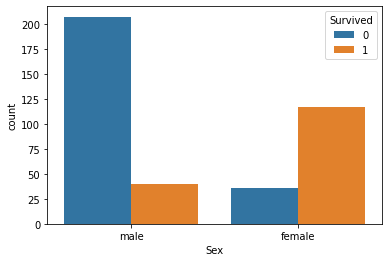

In [575]:
import seaborn as sns
import numpy as np

#load the data
train2 = pd.read_csv(os.path.join(data_folder, "train_400.csv"))

# Visualizations - survived, sex, class, age 
sns.countplot(x="Sex", hue="Survived", data=train2)


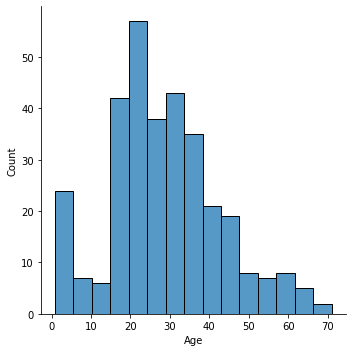

In [576]:
sns.displot(train2, x="Age")

<AxesSubplot:xlabel='Pclass', ylabel='count'>

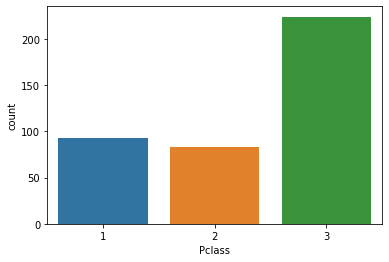

In [577]:
sns.countplot(x="Pclass", data=train2)

In [578]:
# old code used to create a class column in the original train data from above
#conditions = [
    #(train['Pclass_1'] == 1) & (train['Pclass_2'] == 0) & (train['Pclass_3'] == 0),
    #(train['Pclass_1'] == 0) & (train['Pclass_2'] == 1) & (train['Pclass_3'] == 0),
    #(train['Pclass_1'] == 0) & (train['Pclass_2'] == 0) & (train['Pclass_3'] == 1)
    #]

# create a list of the values we want to assign for each condition
#values = ['class_1', 'class_2', 'class_3']

# create a new column and use np.select to assign values to it using our lists as arguments
#train['class'] = np.select(conditions, values)


<AxesSubplot:>

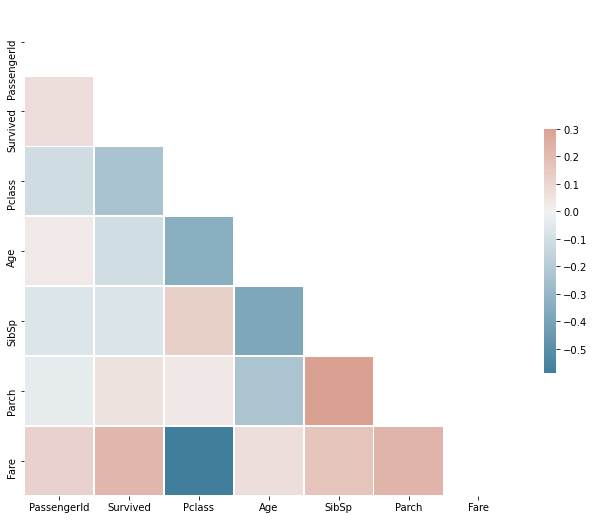

In [579]:
import matplotlib.pyplot as plt
# correlation plot

# Compute the correlation matrix
corr = train2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

[Text(0, 0, 'male'), Text(1, 0, 'female')]

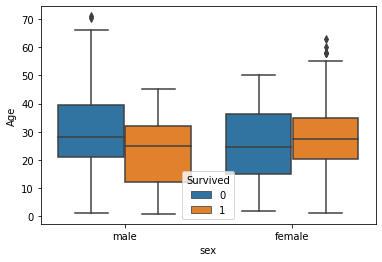

In [580]:
# Boxplot of age, sex and survival
ax = sns.boxplot(x="Sex", y="Age", hue="Survived", data=train2)
ax.set(xlabel="sex")
ax.set_xticklabels(["male", "female"])

# Ridge classifier

In [581]:
# Regularisation: Ridge classifier
from sklearn.linear_model import RidgeClassifier

# create regularisation model
model_rid = RidgeClassifier()

# Fit model on training data
model_rid.fit(X, Y)

# See how well the model does on the training data
yhat = model_rid.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

# Test the model on the testing set
X_test = test.loc[:, train.columns != "Survived"]
Y_test = test["Survived"]

yhat_test = model_rid.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on train data: 0.8114478114478114
Accuracy on test data: 0.9449760765550239


array([[251,  15],
       [  8, 144]])

In [582]:
# Cross-validation - 10fold
from sklearn.model_selection import cross_val_score

scores_rid = cross_val_score(model_rid, X, Y, cv=10)
print('Cross-Validation Accuracy Scores', scores_rid)

scores_rid = pd.Series(scores_rid)
scores_rid.min(), scores_rid.mean(), scores_rid.max()

Cross-Validation Accuracy Scores [0.78888889 0.80898876 0.78651685 0.83146067 0.82022472 0.78651685
 0.78651685 0.7752809  0.83146067 0.83146067]


(0.7752808988764045, 0.8047315855181024, 0.8314606741573034)

# AdaBoost classifier

In [583]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# create adaboost model
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)

# Fit model on training data
abc.fit(X, Y)

# See how well the model does on the training data
yhat = abc.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

# Test the model on the testing set
X_test = test.loc[:, train.columns != "Survived"]
Y_test = test["Survived"]

yhat_test = abc.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on train data: 0.8103254769921436
Accuracy on test data: 0.9354066985645934


array([[241,  25],
       [  2, 150]])

In [584]:
# Cross-validation - 10fold
scores_abc = cross_val_score(abc, X, Y, cv=10)
print('Cross-Validation Accuracy Scores', scores_abc)

scores_abc = pd.Series(scores_abc)
scores_abc.min(), scores_abc.mean(), scores_abc.max()

Cross-Validation Accuracy Scores [0.78888889 0.76404494 0.7752809  0.80898876 0.82022472 0.75280899
 0.80898876 0.82022472 0.80898876 0.83146067]


(0.7528089887640449, 0.7979900124843945, 0.8314606741573034)

# Complement NB

In [585]:
from sklearn.naive_bayes import ComplementNB

# create complementNB model
cnb = ComplementNB()

# Fit model on training data
cnb.fit(X, Y)

# See how well the model does on the training data
yhat = cnb.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

# Test the model on the testing set
X_test = test.loc[:, train.columns != "Survived"]
Y_test = test["Survived"]

yhat_test = cnb.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)



Accuracy on train data: 0.7586980920314254
Accuracy on test data: 0.8803827751196173


array([[218,  48],
       [  2, 150]])

In [586]:
# Cross-validation - 10fold
scores_cnb = cross_val_score(cnb, X, Y, cv=10)
print('Cross-Validation Accuracy Scores', scores_cnb)

scores_cnb = pd.Series(scores_cnb)
scores_cnb.min(), scores_cnb.mean(), scores_cnb.max()

Cross-Validation Accuracy Scores [0.71111111 0.70786517 0.75280899 0.75280899 0.76404494 0.73033708
 0.7752809  0.78651685 0.7752809  0.78651685]


(0.7078651685393258, 0.7542571785268415, 0.7865168539325843)

# Random Forest

In [587]:
from sklearn.ensemble import RandomForestClassifier

# create RandomForest model
rnf = RandomForestClassifier(n_estimators=3)

# Fit model on training data
rnf.fit(X, Y)

# See how well the model does on the training data
yhat = rnf.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

# Test the model on the testing set
X_test = test.loc[:, train.columns != "Survived"]
Y_test = test["Survived"]

yhat_test = rnf.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on train data: 0.8608305274971941
Accuracy on test data: 0.9043062200956937


array([[246,  20],
       [ 20, 132]])

In [588]:
# Cross-validation - 10fold
scores_rnf = cross_val_score(rnf, X, Y, cv=10)
print('Cross-Validation Accuracy Scores', scores_rnf)

scores_rnf = pd.Series(scores_rnf)
scores_rnf.min(), scores_rnf.mean(), scores_rnf.max()

Cross-Validation Accuracy Scores [0.74444444 0.7752809  0.69662921 0.82022472 0.85393258 0.84269663
 0.80898876 0.79775281 0.84269663 0.80898876]


(0.6966292134831461, 0.7991635455680399, 0.8539325842696629)